In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

踩坑:
1. 先配置spark, 再import LightGBMClassifier
2. config需配置com.microsoft.ml.spark:mmlspark_2.11:1.0.0-rc2, 不然会报asci码错误

In [2]:
# com.microsoft.ml.spark:mmlspark_2.11:1.0.0-rc2

spark = SparkSession.builder\
    .appName("My App")\
    .master("local[4]")\
    .config("spark.jars.packages", "com.microsoft.ml.spark:mmlspark_2.11:1.0.0-rc2")\
    .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven")\
    .getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True) # Jupyter查看, 就不需要show()

# LightGBM Classifier

In [3]:
from mmlspark.lightgbm import LightGBMClassifier

## 数据载入

数据获取, kaggle上的数据

https://www.kaggle.com/fedesoriano/company-bankruptcy-prediction

In [4]:
df = spark.read.format("csv")\
    .option("header", True)\
    .option("inferSchema", True)\
    .load("../data/data.csv")

print("records read: " + str(df.count()))
print("Schema: ")
df.printSchema()

records read: 6819
Schema: 
root
 |-- Bankrupt?: integer (nullable = true)
 |--  ROA(C) before interest and depreciation before interest: double (nullable = true)
 |--  ROA(A) before interest and % after tax: double (nullable = true)
 |--  ROA(B) before interest and depreciation after tax: double (nullable = true)
 |--  Operating Gross Margin: double (nullable = true)
 |--  Realized Sales Gross Margin: double (nullable = true)
 |--  Operating Profit Rate: double (nullable = true)
 |--  Pre-tax net Interest Rate: double (nullable = true)
 |--  After-tax net Interest Rate: double (nullable = true)
 |--  Non-industry income and expenditure/revenue: double (nullable = true)
 |--  Continuous interest rate (after tax): double (nullable = true)
 |--  Operating Expense Rate: double (nullable = true)
 |--  Research and development expense rate: double (nullable = true)
 |--  Cash flow rate: double (nullable = true)
 |--  Interest-bearing debt interest rate: double (nullable = true)
 |--  Tax ra

In [5]:
df

+---------+--------------------------------------------------------+---------------------------------------+--------------------------------------------------+-----------------------+----------------------------+----------------------+--------------------------+----------------------------+--------------------------------------------+-------------------------------------+-----------------------+--------------------------------------+-----------------+------------------------------------+-------------------+------------------------+------------------------+------------------------+----------------------------------------+--------------------+---------------------------+------------------------------------+-----------------------------------------+----------------------------------------+-----------------------------+---------------------------------+-------------------------------+----------------------------------+------------------------+----------------------+-------------------------------------+--------------------+-------------------+-------------------+-----------------------+---------------------------+------------------+-----------------+-------------------------------------+---------------------+---------------------------------+---------------------------------+--------------------------------------+--------------------------------------------+---------------------+-----------------------------+------------------------+--------------------------------+--------------------------------+--------------------------------+-------------------+----------------------------+---------------------------+--------------------------------+--------------------------+----------------------------+-------------------+-------------------------------+-----------------------+----------------------------+-----------------------------+--------------------------+----------------------------+------------------------------+-----------------------+---------------------------+--------------------------------------+----------------------------------+---------------------------+---------------------+----------------------------+--------------------------+-------------------------------+-------------------+-------------------+-----------------------+-------------------------------+----------------------------+------------------------------+--------------------------+-----------------------+-----------------+--------------------+------------------------------------+----------------------+---------------------------+--------------------------+-------------------+----------------------+-----------------------------------+--------------------+-----------------------------------+---------------------------------------------------+----------------+--------------------+
|Bankrupt?| ROA(C) before interest and depreciation before interest| ROA(A) before interest and % after tax| ROA(B) before interest and depreciation after tax| Operating Gross Margin| Realized Sales Gross Margin| Operating Profit Rate| Pre-tax net Interest Rate| After-tax net Interest Rate| Non-industry income and expenditure/revenue| Continuous interest rate (after tax)| Operating Expense Rate| Research and development expense rate|   Cash flow rate| Interest-bearing debt interest rate|       Tax rate (A)| Net Value Per Share (B)| Net Value Per Share (A)| Net Value Per Share (C)| Persistent EPS in the Last Four Seasons| Cash Flow Per Share| Revenue Per Share (Yuan ¥)| Operating Profit Per Share (Yuan ¥)| Per Share Net profit before tax (Yuan ¥)| Realized Sales Gross Profit Growth Rate| Operating Profit Growth Rate| After-tax Net Profit Growth Rate| Regular Net Profit Growth Rate| Continuous Net Profit Growth Rate| Total Asset Growth Rate| Net Value Growth Rate| Total Asset Return Growth Rate Ratio| Cash Reinvestment %|      Current Ratio|        Quick Ratio| Interest Expense Ratio| Total debt/Total net worth|      Debt ratio %| Net worth/Assets| Long-term fund suitability ratio (A)| Borro

limit_output extension: Maximum message size of 10000 exceeded with 67032 characters

## 划分训练集/测试集

In [6]:
train, test = df.randomSplit([0.85, 0.15], seed=1)

## 转换features

In [7]:
feature_cols = df.columns[1:]
featurizer = VectorAssembler(
    inputCols=feature_cols,
    outputCol='features'
)

train_data = featurizer.transform(train)['Bankrupt?', 'features']
test_data = featurizer.transform(test)['Bankrupt?', 'features']

## 查看数据集分布

In [8]:
train_data.groupBy('Bankrupt?').count()

Bankrupt?,count
1,181
0,5574


## 训练

In [9]:
model = LightGBMClassifier(
    objective="binary",
    featuresCol="features",
    labelCol="Bankrupt?",
    isUnbalance=True
)

In [10]:
train_data

Bankrupt?,features
0,"[0.0,0.0069232446..."
0,[0.08282552527665...
0,[0.23136547555208...
0,[0.23745917223224...
0,[0.24984156388631...
0,[0.26432018719836...
0,[0.26900014624872...
0,[0.28333252084044...
0,[0.30190610832155...
0,[0.32325842148881...


In [11]:
model = model.fit(train_data)

In [12]:
from mmlspark.lightgbm import LightGBMClassificationModel
model.saveNativeModel("/lgbmclassifier.model")
model = LightGBMClassificationModel.loadNativeModelFromFile("/lgbmclassifier.model")

f_index: Index([' Liability-Assets Flag', ' Current Liability to Equity',
       ' Net Income Flag', ' Operating Profit Per Share (Yuan ¥)',
       ' Net Value Per Share (C)', ' Current Ratio',
       ' After-tax net Interest Rate', ' Cash Flow to Sales',
       ' Net Value Per Share (A)', ' Operating profit/Paid-in capital',
       ' Tax rate (A)', ' After-tax Net Profit Growth Rate',
       ' Realized Sales Gross Margin', ' Liability to Equity',
       ' Working Capital/Equity', ' Current Liability to Current Assets',
       ' Operating Profit Growth Rate', ' Revenue Per Share (Yuan ¥)',
       ' Net profit before tax/Paid-in capital', ' Equity to Liability',
       ' Per Share Net profit before tax (Yuan ¥)', ' Gross Profit to Sales',
       ' Cash flow rate', ' Current Assets/Total Assets',
       ' Net Worth Turnover Rate (times)', ' Current Liability to Liability',
       ' Net Income to Stockholder's Equity',
       ' Working Capital to Total Assets', ' Cash Flow to Total Assets

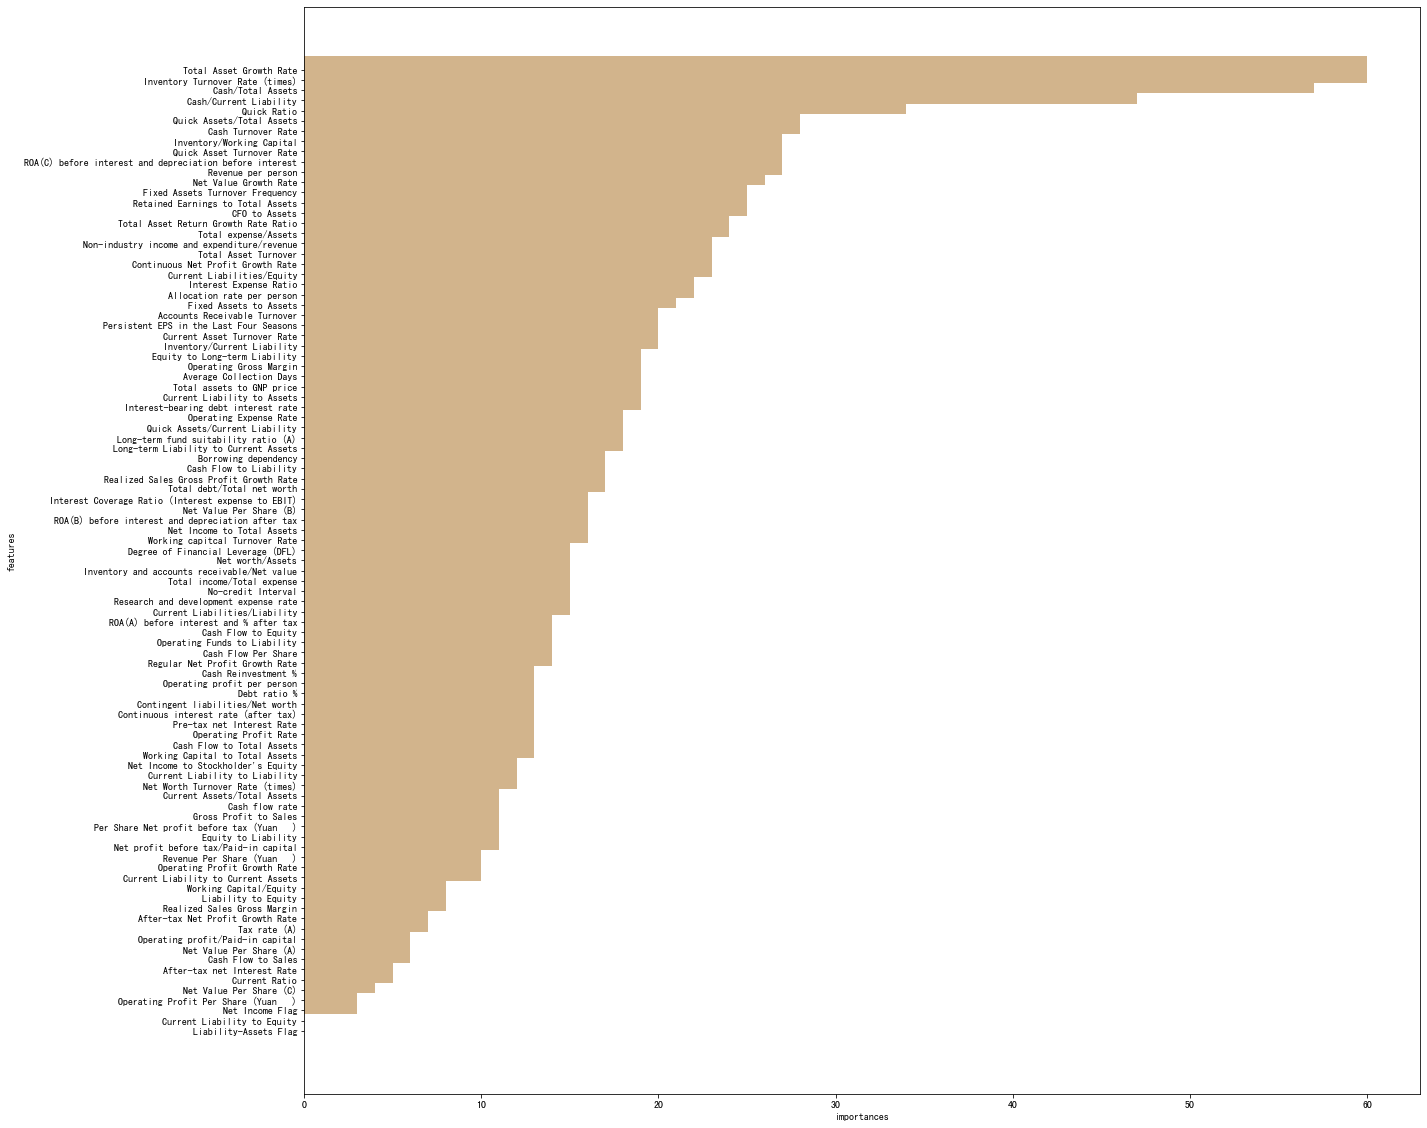

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = model.getFeatureImportances()
fi = pd.Series(feature_importances, index=feature_cols)
fi = fi.sort_values(ascending=True)
f_index = fi.index
f_values = fi.values
 
# print feature importances 
print('f_index:', f_index)
print('f_values:', f_values)

# plot
x_index = list(range(len(fi)))
x_index = [x / len(fi) for x in x_index]
plt.rcParams['figure.figsize'] = (20,20)
plt.barh(x_index, f_values, height=0.028 ,align="center", color='tan', tick_label=f_index)
plt.xlabel('importances')
plt.ylabel('features')
plt.show()

In [14]:
predictions = model.transform(test_data)
predictions.limit(10).toPandas()

,Bankrupt?,features,rawPrediction,probability,prediction
0,0,"[0.249305318578462, 0.259376362843437, 0.25938...","[1576.322120783564, -1576.322120783564]","[1.0, 0.0]",0.0
1,0,"[0.306244820357822, 0.331934147405146, 0.34755...","[-1188.5304918919246, 1188.5304918919246]","[0.0, 1.0]",1.0
2,0,"[0.339345780724419, 0.390263846489315, 0.38396...","[2042.804620989677, -2042.804620989677]","[1.0, 0.0]",0.0
3,0,"[0.364841807634183, 0.31841474051461, 0.393115...","[611.4681006200382, -611.4681006200382]","[1.0, 2.7719030788539283e-266]",0.0
4,0,"[0.374737971042753, 0.433111644134322, 0.40789...","[750.3080248007714, -750.3080248007714]","[1.0, 0.0]",0.0
5,0,"[0.37581046165846, 0.453227213257741, 0.453236...","[-235.72097826324455, 235.72097826324455]","[0.0, 1.0]",1.0
6,0,"[0.383366645541851, 0.427660270388138, 0.42132...","[903.585408543812, -903.585408543812]","[1.0, 0.0]",0.0
7,0,"[0.386827865256179, 0.434419973833406, 0.43953...","[2072.8685224025157, -2072.8685224025157]","[1.0, 0.0]",0.0
8,0,"[0.405547701457612, 0.450392498909725, 0.45221...","[-465.6999348620068, 465.6999348620068]","[0.0, 1.0]",1.0
9,0,"[0.410276410081412, 0.467455298735281, 0.45741...","[-112.6408422606815, 112.6408422606815]","[0.0, 1.0]",1.0


In [15]:
from mmlspark.train import ComputeModelStatistics
metrics = ComputeModelStatistics(evaluationMetric="classification", labelCol='Bankrupt?', scoredLabelsCol='prediction').transform(predictions)
display(metrics)

evaluation_type,confusion_matrix,accuracy,precision,recall,AUC
Classification,942.0 83.0 14....,0.9088345864661654,0.23148148148148148,0.6410256410256411,0.7800250156347718


# 回归

数据获取, 在linux目录下执行以下命令

!wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression/triazines_scale

In [16]:
triazines = spark.read.format("libsvm")\
    .load("../data/triazines_scale")

In [17]:
# print some basic info
print("records read: " + str(triazines.count()))
print("Schema: ")
triazines.printSchema()
display(triazines.limit(10))

records read: 186
Schema: 
root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



label,features
0.809,"(60,[0,1,2,3,4,5,..."
0.602,"(60,[0,3,4,5,6,8,..."
0.442,"(60,[0,1,2,3,4,5,..."
0.718,"(60,[0,1,2,3,4,5,..."
0.697,"(60,[0,1,2,3,4,5,..."
0.757,"(60,[0,1,2,3,4,6,..."
0.9,"(60,[0,1,2,3,4,6,..."
0.564,"(60,[0,1,2,3,4,5,..."
0.772,"(60,[0,1,2,3,4,6,..."
0.801,"(60,[0,1,2,3,4,6,..."


In [18]:
train, test = triazines.randomSplit([0.85, 0.15], seed=1)

In [19]:
from mmlspark.lightgbm import LightGBMRegressor
model = LightGBMRegressor(
    objective='quantile',
    alpha=0.2,
    learningRate=0.3,
    numLeaves=31
).fit(train)

In [20]:
print(model.getFeatureImportances())

[39.0, 41.0, 26.0, 0.0, 19.0, 2.0, 0.0, 9.0, 11.0, 4.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 52.0, 61.0, 19.0, 17.0, 36.0, 0.0, 6.0, 4.0, 29.0, 21.0, 8.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 1.0, 8.0, 18.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


In [21]:
scoredData = model.transform(test)
display(scoredData)

label,features,prediction
0.195,"(60,[0,1,2,3,4,5,...",0.2500845902448115
0.365,"(60,[0,1,2,4,5,6,...",0.5669223869439056
0.45,"(60,[0,1,2,3,4,5,...",0.7774221631611411
0.523,"(60,[0,1,2,3,4,5,...",0.6035040847600094
0.55,"(60,[0,1,2,3,4,5,...",0.5869461996456875
0.558,"(60,[0,1,2,3,4,5,...",0.5956667413651838
0.581,"(60,[0,1,2,3,4,5,...",0.29859775069061306
0.602,"(60,[0,3,4,5,6,8,...",0.45926432474617745
0.666,"(60,[0,1,2,3,4,5,...",0.6803800406519865
0.678,"(60,[0,1,2,3,4,6,...",0.5856478205569542


In [22]:
from mmlspark.train import ComputeModelStatistics
metrics = ComputeModelStatistics(
    evaluationMetric='regression',
    labelCol='label',
    scoresCol='prediction'
).transform(scoredData)
display(metrics)

mean_squared_error,root_mean_squared_error,R^2,mean_absolute_error
0.017162040529625295,0.13100397142692008,0.19122995105948137,0.10537563246978685


# LightGBM Ranker

In [23]:

# df = spark.read.format("parquet").load("wasbs://publicwasb@mmlspark.blob.core.windows.net/lightGBMRanker_train.parquet")
# # print some basic info
# print("records read: " + str(df.count()))
# print("Schema: ")
# df.printSchema()
# display(df.limit(10))

In [24]:
# from mmlspark.lightgbm import LightGBMRanker

# features_col = 'features'
# query_col = 'query'
# label_col = 'labels'
# lgbm_ranker = LightGBMRanker(labelCol=label_col,
#                              featuresCol=features_col,
#                              groupCol=query_col,
#                              predictionCol='preds',
#                              leafPredictionCol='leafPreds',
#                              featuresShapCol='importances',
#                              repartitionByGroupingColumn=True,
#                              numLeaves=32,
#                              numIterations=200,
#                              evalAt=[1,3,5],
#                              metric='ndcg')

In [25]:
# lgbm_ranker_model = lgbm_ranker.fit(df)

In [26]:
# dt = spark.read.format("parquet").load("wasbs://publicwasb@mmlspark.blob.core.windows.net/lightGBMRanker_test.parquet")
# predictions = lgbm_ranker_model.transform(dt)
# predictions.limit(10).toPandas()